#  Résolution du modèle NewsVendor

<a name="0"></a>
## Libraries

In [1]:
#Load our local fonctions
from utils_resolution import *
# load librairies
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
sns.set_style("whitegrid")
import scipy.stats as stats

import warnings
warnings.filterwarnings('ignore')

<a name="0"></a>
## 1 - Anticipation des facteurs d'incertitudes

In [2]:
from sklearn.model_selection import train_test_split, StratifiedKFold, cross_val_score
from joblib import dump, load
from sklearn.metrics import accuracy_score, roc_auc_score, precision_score, recall_score, f1_score,confusion_matrix, classification_report
from sklearn.model_selection import learning_curve
from sklearn.ensemble import RandomForestClassifier
from imblearn.over_sampling import SMOTE
from sklearn.model_selection import train_test_split, GridSearchCV
from keras.models import load_model

In [3]:
df = pd.read_csv("data_st/data_prep.csv")

In [4]:
# Convertir la colonne 'activitydatetime' en format datetime si ce n'est pas déjà fait
df['activitydatetime'] = pd.to_datetime(df['activitydatetime'])

# Définir la date de référence (dernier jour) et calculer la date de début (10 jours avant)
end_date = df['activitydatetime'].max() 
start_date = end_date - pd.Timedelta(days=10)

# Filtrer les données pour les 10 derniers jours
data_filtered = df[(df['activitydatetime'] >= start_date) & (df['activitydatetime'] <= end_date)]

# Trouver le sta3n avec le plus de rendez-vous dans ces 10 jours
most_common_sta3n = data_filtered['sta3n'].value_counts().idxmax()

# Filtrer le dataFrame pour ce stopcode spécifique
data = data_filtered[data_filtered['sta3n'] == most_common_sta3n]

In [5]:
data

,patientsid,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,NoShow,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg
2006992,10683380,2023-08-29 19:57:51,589,150,2.0,7,1,653.0,MISSOURI,0,0,1,1,29,8,19,23,0.0,10.500000
2007339,10684474,2023-08-24 21:02:38,589,307,1.0,34,0,641.0,MISSOURI,0,0,1,3,24,8,21,26,0.0,12.666667
2007411,10684734,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,MISSOURI,1,0,1,0,21,8,15,120,0.0,2.000000
2007421,10684765,2023-08-30 14:33:57,589,323,4.0,9,1,673.0,KANSAS,0,0,0,2,30,8,14,35,0.0,4.500000
2007509,10684967,2023-08-25 14:52:50,589,160,0.0,7,0,641.0,MISSOURI,0,0,1,4,25,8,14,39,0.0,14.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11341458,1604948062,2023-08-29 16:55:24,589,502,0.0,1,0,660.0,KANSAS,0,0,1,1,29,8,16,11,0.0,14.000000
11341500,1604950258,2023-08-30 15:16:37,589,301,10.0,28,0,660.0,KANSAS,1,0,0,2,30,8,15,8,0.0,14.000000
11341769,1604964585,2023-08-23 13:50:24,589,510,0.0,0,0,655.0,MISSOURI,0,0,1,2,23,8,13,1,0.0,14.000000
11342009,1604979330,2023-08-28 07:49:29,589,304,0.0,0,1,675.0,KANSAS,0,0,1,0,28,8,7,3,0.0,14.000000


In [6]:
data.drop(['patientsid'], axis = True, inplace=True)

In [7]:
from sklearn.preprocessing import LabelEncoder, OneHotEncoder
label_encoder = LabelEncoder()
data['state'] = label_encoder.fit_transform(data['state'])

In [8]:
# Division des données en ensembles d'entraînement et de test
X = data.drop('NoShow', axis=1)
y = data['NoShow']

In [9]:
X_init = X.copy()
X.drop('activitydatetime', axis=1, inplace=True)

In [10]:
y.value_counts()

0    1672
1      88
Name: NoShow, dtype: int64

In [11]:
from sklearn.preprocessing import MinMaxScaler

# Initialiser le MinMaxScaler
# Normalisation des données après le sampling
scaler = MinMaxScaler()
X = scaler.fit_transform(X)

### Models

In [12]:
# Chargement du modèle
model = load_model('model_mlp_ns_best.keras')
print(model.summary())

Model: "sequential_1"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ dense_4 (Dense)                      │ (None, 16)                  │             272 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_2 (Dropout)                  │ (None, 16)                  │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_5 (Dense)                      │ (None, 8)                   │             136 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 8)                   │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 4)                   │              36 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 1)                   │               5 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 1,349 (5.27 KB)

 Trainable params: 449 (1.75 KB)

 Non-trainable params: 0 (0.00 B)

 Optimizer params: 900 (3.52 KB)

None


In [13]:
# Get probabilities for the positive class
y_proba_ann = model.predict(X)[:, 0]

55/55 ━━━━━━━━━━━━━━━━━━━━ 1s 3ms/step


In [14]:
threshold=0.5
# Apply threshold to convert probabilities to binary classification
y_pred_ann = (y_proba_ann >= threshold).astype(int)

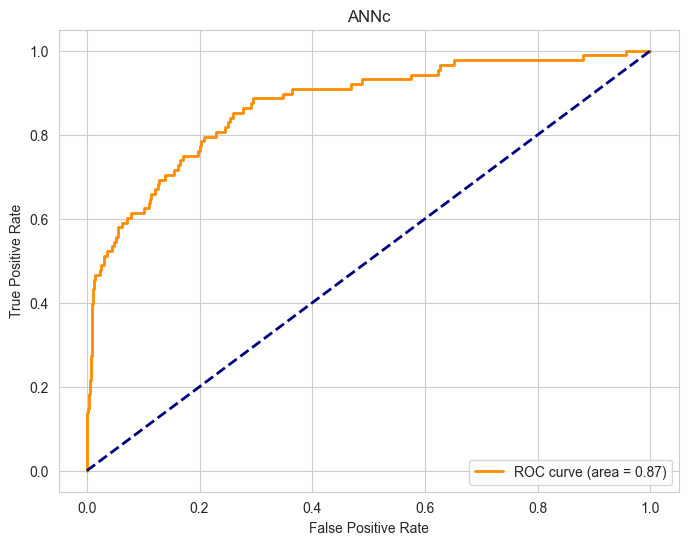

In [15]:
# Calcul des taux pour la courbe ROC
fpr, tpr, _ = roc_curve(y, y_proba_ann)
roc_auc = auc(fpr, tpr)

# Tracé de la courbe ROC
plt.figure(figsize=(8, 6))
plt.plot(fpr, tpr, color='darkorange', lw=2, label='ROC curve (area = %0.2f)' % roc_auc)
plt.plot([0, 1], [0, 1], color='navy', lw=2, linestyle='--')
plt.xlabel('False Positive Rate')
plt.ylabel('True Positive Rate')
plt.title('ANNc')
plt.legend(loc="lower right")
plt.grid(True)
plt.show()

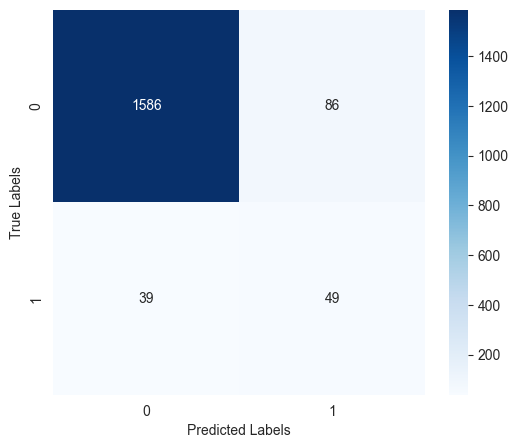

,Metric,Test
0,Recall,0.752691
1,AUC,0.871031
2,Accuracy,0.928977
3,Precision,0.669481
4,F1 Score,0.700774


In [16]:
evaluate_model(model, X, y, y_proba_ann, y_pred_ann)

In [17]:
data_ns_predicted = concatenate_results(X_init, y, y_proba_ann, y_pred_column_name='predicted_NoShow')

In [18]:
data_ns_predicted[(data_ns_predicted['NoShow'] == 1) & (data_ns_predicted['predicted_NoShow']  >  0.5)].head()

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg,NoShow,predicted_NoShow
2,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,11,0,1,0,21,8,15,120,0.0,2.0,1,0.573596
21,2023-08-25 09:56:46,589,212,48.0,12,1,647.0,11,0,1,4,25,8,9,36,0.0,11.0,1,0.798607
24,2023-08-30 08:06:45,589,304,8.0,1,0,641.0,11,0,1,2,30,8,8,5,0.0,8.8,1,0.705812
40,2023-08-22 09:23:55,589,160,9.0,16,0,641.0,11,0,1,1,22,8,9,25,0.0,6.0,1,0.767896
81,2023-08-21 11:49:11,589,502,34.0,0,0,785.0,17,0,1,0,21,8,11,64,0.0,10.0,1,0.889667


In [19]:
# Filtrer les cas où la probabilité de no-show est inférieure à 0.5
data_low_proba_noshow  = data_ns_predicted[data_ns_predicted['predicted_NoShow'] < 0.5].copy()

In [20]:
data_low_proba_noshow.head()

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg,NoShow,predicted_NoShow
0,2023-08-29 19:57:51,589,150,2.0,7,1,653.0,11,0,1,1,29,8,19,23,0.0,10.500000,0,0.268092
1,2023-08-24 21:02:38,589,307,1.0,34,0,641.0,11,0,1,3,24,8,21,26,0.0,12.666667,0,0.057283
4,2023-08-25 14:52:50,589,160,0.0,7,0,641.0,11,0,1,4,25,8,14,39,0.0,14.250000,0,0.032245
5,2023-08-30 08:36:02,589,307,0.0,3,0,661.0,7,0,1,2,30,8,8,16,0.0,3.000000,0,0.117190
6,2023-08-28 18:27:27,589,304,0.0,4,0,640.0,11,0,1,0,28,8,18,35,0.0,1.000000,0,0.027463


In [21]:
X = data_low_proba_noshow.drop('service_time', axis=1) 
y = data_low_proba_noshow['service_time']

In [22]:
X = X.drop(columns=['NoShow', 'predicted_NoShow'], axis = 1)

In [23]:
from sklearn.preprocessing import MinMaxScaler
# Initialiser le MinMaxScaler
# Normalisation des données après le sampling
scaler = MinMaxScaler()
X = scaler.fit_transform(X.drop('activitydatetime', axis=1))

In [24]:
from keras.models import load_model
# Charge le modèle
best_ann_st = load_model('modele_st_mlp_v6.keras')
print("Modèle chargé avec succès.")

Modèle chargé avec succès.


In [25]:
from sklearn.metrics import mean_squared_error, mean_absolute_error, r2_score, accuracy_score
from sklearn.utils import shuffle

In [26]:
# Make predictions
y_pred_ann = best_ann_st.predict(X).flatten()  # Flatten is used to match the shape of y_test

51/51 ━━━━━━━━━━━━━━━━━━━━ 0s 4ms/step


In [27]:
y_pred_ann

array([11.149415, 23.848183, 18.946194, ..., 18.946194, 17.776615,
       19.58213 ], dtype=float32)

In [28]:
evaluate_mlp_model(best_ann_st, X, y, y_pred_ann)

{'R-squared': -0.009080165850962274,
 'Mean Absolute Error': 18.061011632479154,
 'Mean Squared Error': 825.2640577719188,
 'Root Mean Squared Error': 28.72740952073331}

In [29]:
# Ajouter les prédictions dans le dataFrame filtré
data_low_proba_noshow['predicted_service_time'] = y_pred_ann

# Mettre à jour la colonne 'predicted_service_time' dans le dataFrame original
data_ns_predicted['predicted_service_time'] = 0  # Initialiser à 0 pour tous les cas
data_ns_predicted.loc[data_low_proba_noshow.index, 'predicted_service_time'] = data_low_proba_noshow['predicted_service_time']

In [30]:
data_ns_predicted.head()

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg,NoShow,predicted_NoShow,predicted_service_time
0,2023-08-29 19:57:51,589,150,2.0,7,1,653.0,11,0,1,1,29,8,19,23,0.0,10.500000,0,0.268092,11.149415
1,2023-08-24 21:02:38,589,307,1.0,34,0,641.0,11,0,1,3,24,8,21,26,0.0,12.666667,0,0.057283,23.848183
2,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,11,0,1,0,21,8,15,120,0.0,2.000000,1,0.573596,0.000000
3,2023-08-30 14:33:57,589,323,4.0,9,1,673.0,7,0,0,2,30,8,14,35,0.0,4.500000,0,0.530322,0.000000
4,2023-08-25 14:52:50,589,160,0.0,7,0,641.0,11,0,1,4,25,8,14,39,0.0,14.250000,0,0.032245,18.946194


In [31]:
# Fonction pour enregistrer un dataFrame en CSV dans le répertoire 'preprocessed'
def save_dataframe(data, name):
    filename = f'data_simulation/{name}.csv'
    data.to_csv(filename, index=False)


In [32]:
data_predicted = data_ns_predicted.sort_values(by='activitydatetime', ascending=True)

In [33]:
# Liste des colonnes à formater
columns_to_format = ['predicted_NoShow', 'predicted_service_time', 'prior_noShow_rate', 'prior_service_time_avg']

# Appliquer le formatage à deux chiffres après la virgule
data_predicted[columns_to_format] = data_ns_predicted[columns_to_format].round(2)

In [34]:
save_dataframe(data_ns_predicted, 'data_10_days')

# Résolution

Étape 1: Définition des variables

    X : Nombre de No-show (variable aléatoire représentant la demande aléatoire de No-show).
    Y : Niveau optimal d'overbooking (nombre de rendez-vous supplémentaires à accepter pour maximiser le bénéfice attendu ou minimiser les coûts).
    C : Capacité totale des médecins en temps de service (en unités de temps).

Étape 2: Initialisation des paramètres

    λ (lambda) : Coût de l'overbooking (par exemple, coût d'un patient en plus qui se présente en raison de l'overbooking).
    ρ (rho) : Coût de l'opportunité perdue (par exemple, coût associé à un créneau inutilisé dû à un no-show).

In [35]:
#Normalize to put zero in service time where there is No-show
data.loc[data['NoShow'] == "1", 'service_time'] = 0

In [36]:
data[data['NoShow'] == 1]

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,NoShow,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg
2007411,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,11,1,0,1,0,21,8,15,120,0.0,2.0
2010017,2023-08-25 09:56:46,589,212,48.0,12,1,647.0,11,1,0,1,4,25,8,9,36,0.0,11.0
2010773,2023-08-30 08:06:45,589,304,8.0,1,0,641.0,11,1,0,1,2,30,8,8,5,0.0,8.8
2013212,2023-08-22 09:23:55,589,160,9.0,16,0,641.0,11,1,0,1,1,22,8,9,25,0.0,6.0
2016220,2023-08-25 08:56:07,589,303,1.0,0,0,661.0,7,1,0,1,4,25,8,8,0,0.0,8.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11331050,2023-08-30 20:11:53,589,436,35.0,8,0,662.0,7,1,0,1,2,30,8,20,36,0.0,14.0
11332696,2023-08-21 08:43:06,589,304,77.0,0,0,641.0,11,1,0,1,0,21,8,8,0,0.0,14.0
11338272,2023-08-22 13:39:57,589,436,83.0,2,0,665.0,7,1,0,1,1,22,8,13,8,0.0,14.0
11340215,2023-08-30 14:13:19,589,160,17.0,13,0,665.0,7,1,0,1,2,30,8,14,29,0.0,14.0


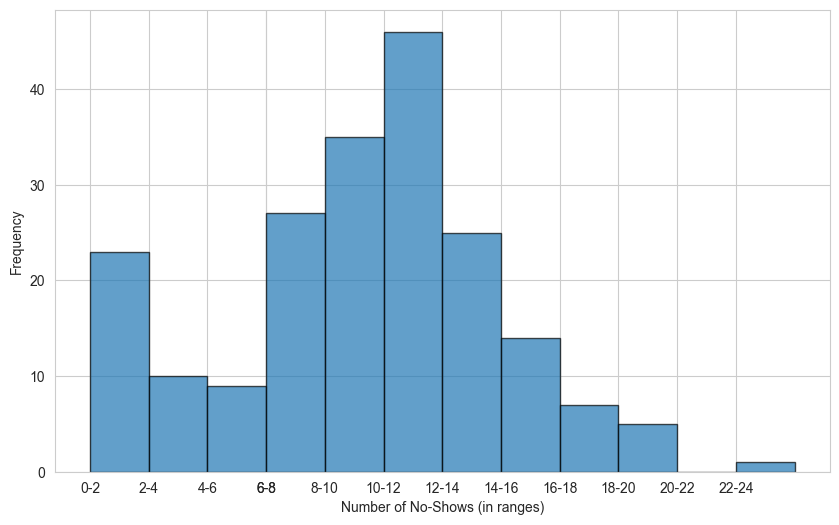

In [37]:
no_show_history = extract_no_show_history(df, sta3n=589, year=2023)

# Tracer l'histogramme de la distribution des No-show
plot_no_show_histogram(no_show_history)

### Sensitivity Analysis

In [38]:
data

,activitydatetime,sta3n,stopcode,dta,dts,non_va,zip,state,NoShow,discontinued,typecare,day_of_week,day_of_month,month,hour,service_time,prior_noShow_rate,prior_service_time_avg
2006992,2023-08-29 19:57:51,589,150,2.0,7,1,653.0,11,0,0,1,1,29,8,19,23,0.0,10.500000
2007339,2023-08-24 21:02:38,589,307,1.0,34,0,641.0,11,0,0,1,3,24,8,21,26,0.0,12.666667
2007411,2023-08-21 15:06:10,589,212,27.0,16,1,647.0,11,1,0,1,0,21,8,15,120,0.0,2.000000
2007421,2023-08-30 14:33:57,589,323,4.0,9,1,673.0,7,0,0,0,2,30,8,14,35,0.0,4.500000
2007509,2023-08-25 14:52:50,589,160,0.0,7,0,641.0,11,0,0,1,4,25,8,14,39,0.0,14.250000
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
11341458,2023-08-29 16:55:24,589,502,0.0,1,0,660.0,7,0,0,1,1,29,8,16,11,0.0,14.000000
11341500,2023-08-30 15:16:37,589,301,10.0,28,0,660.0,7,1,0,0,2,30,8,15,8,0.0,14.000000
11341769,2023-08-23 13:50:24,589,510,0.0,0,0,655.0,11,0,0,1,2,23,8,13,1,0.0,14.000000
11342009,2023-08-28 07:49:29,589,304,0.0,0,1,675.0,7,0,0,1,0,28,8,7,3,0.0,14.000000


In [59]:


def sensitivity_analysis(data, no_show_history, sta3n=657, num_days=10, lambda_values=[50, 100], rho_values=[50, 100]):
    colors = ['red', 'blue', 'green', 'purple']
    markers = ['o', 's', '^', 'D']
    
    plt.figure(figsize=(12, 6))
    
    results_data, no_show_vs_overbooking_data = process_last_n_days(data, 2, 1, no_show_history, sta3n, num_days)
        
    plt.plot(no_show_vs_overbooking_data['date'], no_show_vs_overbooking_data['X'], linestyle=':', color='black', marker=markers[1], label=f'No-show (X)')
    for i, (lambda_cost, rho_cost) in enumerate(zip(lambda_values, rho_values)):
        results_data, no_show_vs_overbooking_data = process_last_n_days(data, lambda_cost, rho_cost, no_show_history, sta3n, num_days)
        
        plt.plot(no_show_vs_overbooking_data['date'], no_show_vs_overbooking_data['Y_star'], linestyle='-', color=colors[i], marker=markers[i], label=f'Optimal Overbooking (Y*) λ={lambda_cost}, ρ={rho_cost}')
    
    plt.xlabel('Date')
    plt.ylabel('Noshow count/optimal overbooking limit')
    plt.legend()
    plt.grid(True)
    plt.show()

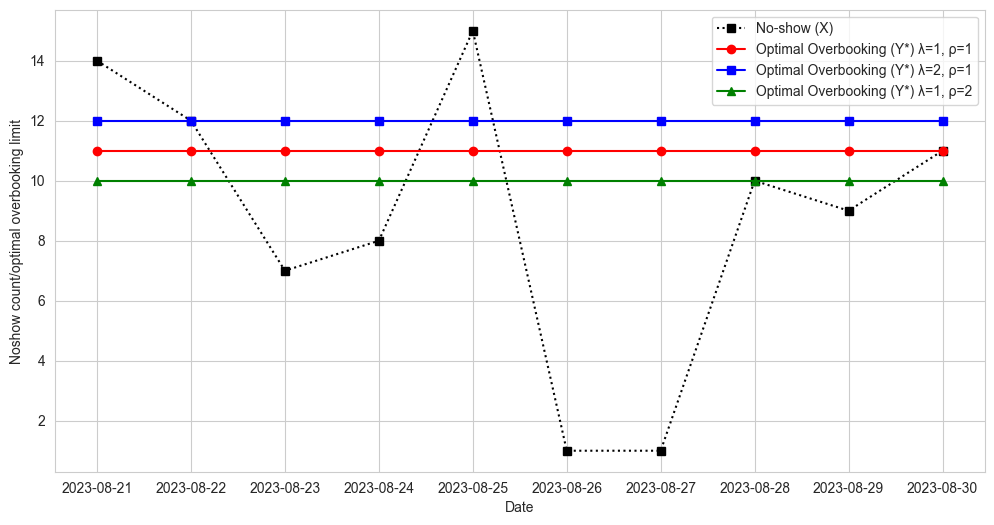

In [60]:
lambda_values = [1, 2, 1]
rho_values = [1, 1, 2]
sensitivity_analysis(data, no_show_history, sta3n=589, num_days=10, lambda_values=lambda_values, rho_values=rho_values)

## Généric distribution

In [51]:
# Exemple d'utilisation
lambda_cost = 100
rho_cost = 50
sta3n = 589
num_days = 10  

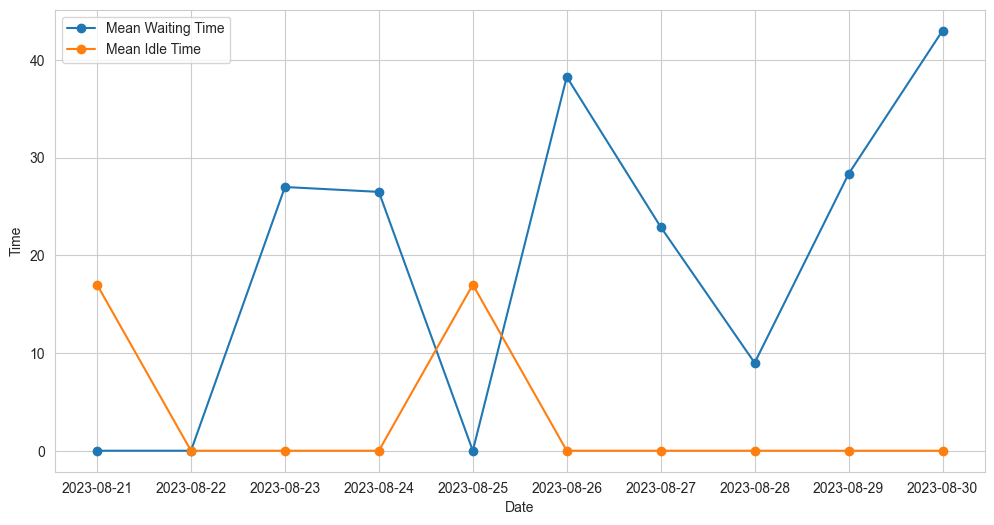

In [52]:
# Calculer les variations pour les N derniers jours pour un sta3n spécifique
results_data, no_show_vs_overbooking_data = process_last_n_days(data, lambda_cost, rho_cost, no_show_history, sta3n=sta3n, num_days=num_days)

# Tracer les variations des temps d'attente et des temps morts
plot_variations(results_data)


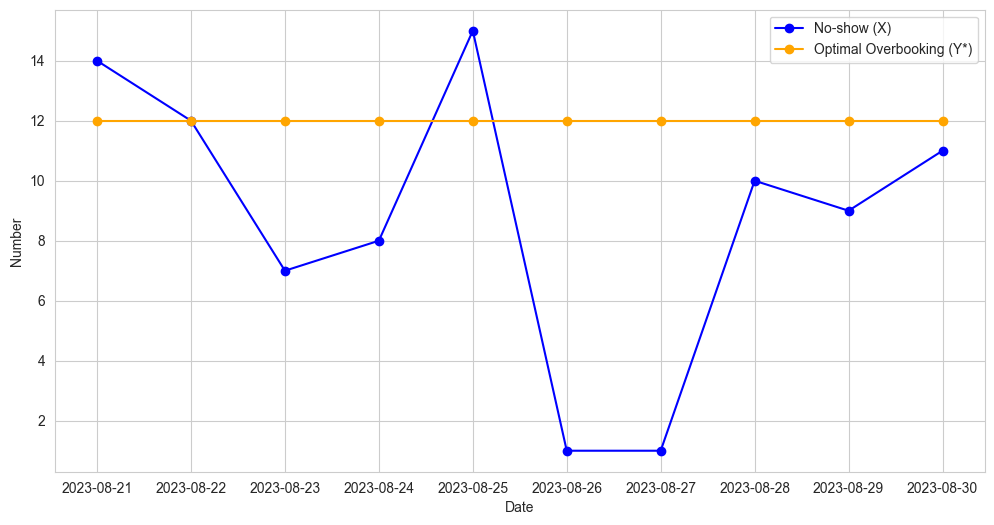

In [53]:
# Tracer les variations entre X et Y*
plot_no_show_vs_overbooking(no_show_vs_overbooking_data)

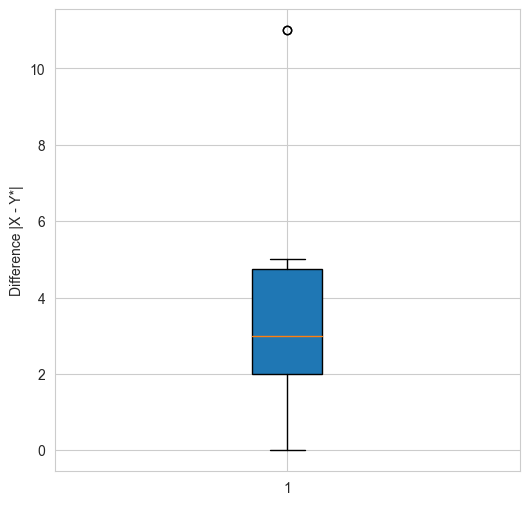

In [54]:
# Tracer le boxplot pour mesurer la dispersion entre X et Y*
plot_dispersion_boxplot(no_show_vs_overbooking_data)

#### Variation with predicted values

In [55]:
# Calculer les variations pour les N derniers jours pour un sta3n spécifique
results_data_predicted, no_show_vs_overbooking_data = process_last_n_days(data_predicted, lambda_cost, rho_cost, no_show_history, 
                                                                          service_time ="predicted_service_time", sta3n=sta3n, num_days=num_days)

# Tracer les variations des temps d'attente et des temps morts
plot_variations(results_data_predicted)

TypeError: process_last_n_days() got an unexpected keyword argument 'service_time'

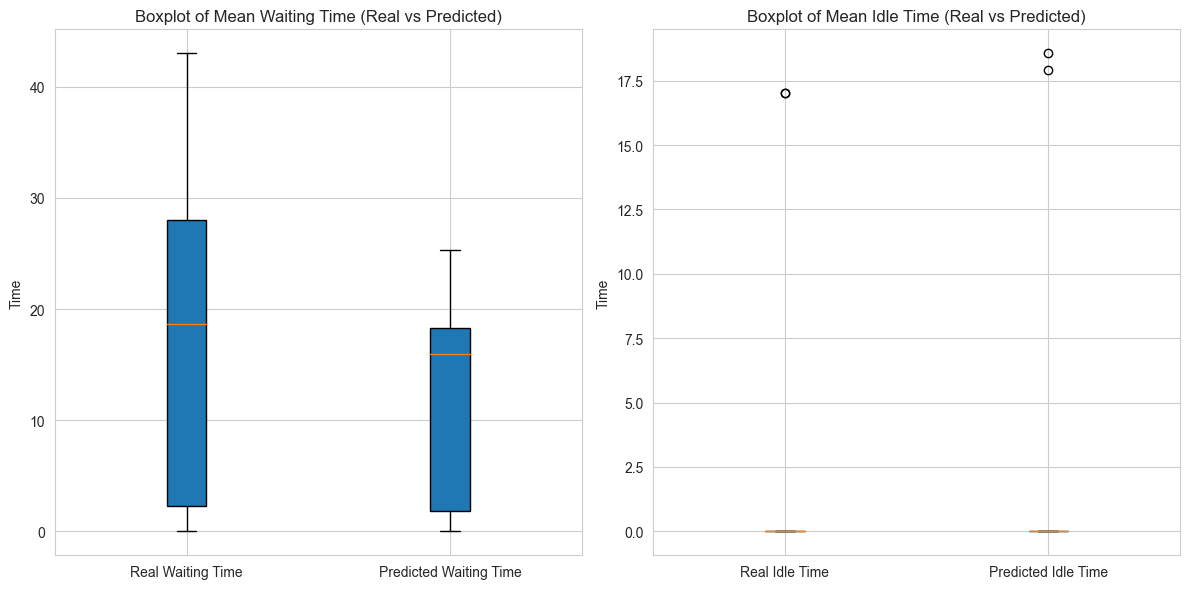

In [59]:
# Calculer les variations pour les N derniers jours pour un sta3n spécifique avec les valeurs réelles
results_data, no_show_vs_overbooking_data = process_last_n_days(data, lambda_cost, rho_cost, no_show_history, sta3n=sta3n, num_days=num_days)

# Calculer les variations pour les N derniers jours pour un sta3n spécifique avec les valeurs prédites
results_data_predicted, no_show_vs_overbooking_data_predicted = process_last_n_days(data_predicted, lambda_cost, rho_cost, no_show_history, service_time="predicted_service_time", sta3n=sta3n, num_days=num_days)

# Tracer les boxplots des temps d'attente et des temps morts pour les valeurs réelles et prédites
plot_boxplots(results_data, results_data_predicted)

## uniform distribution

In [ ]:
# Calcul de la moyenne et de l'écart-type
m = no_show_history['no_show_count'].mean()
s = no_show_history['no_show_count'].std()

In [50]:
# Exemple d'utilisation
lambda_cost = 2
rho_cost = 1
sta3n = 657
num_days = 10 


df['activitydatetime'] = pd.to_datetime(df['activitydatetime'])

# Calculer les variations pour les N derniers jours pour un sta3n spécifique
results_data, no_show_vs_overbooking_data = process_last_n_days(df, lambda_cost, rho_cost, m, s, sta3n=sta3n, num_days=num_days)

# Tracer les variations des temps d'attente et des temps morts
plot_variations(results_data)

NameError: name 'm' is not defined

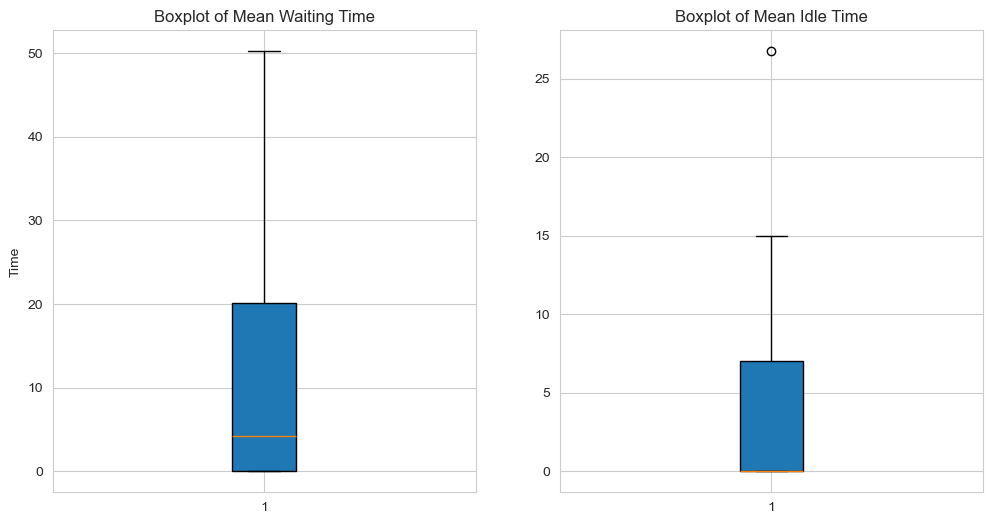

In [310]:
# Tracer les boxplots des temps d'attente et des temps morts
plot_boxplots(results_data)

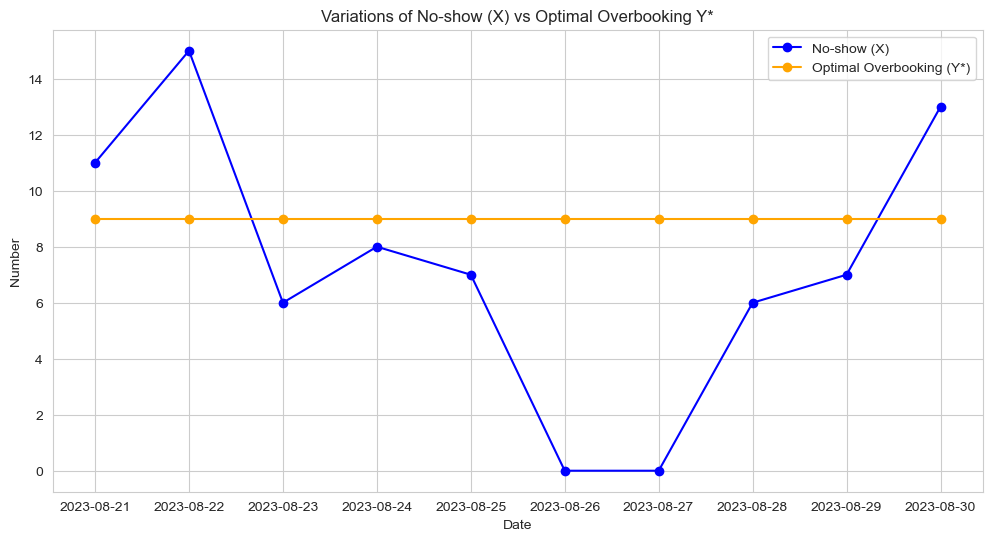

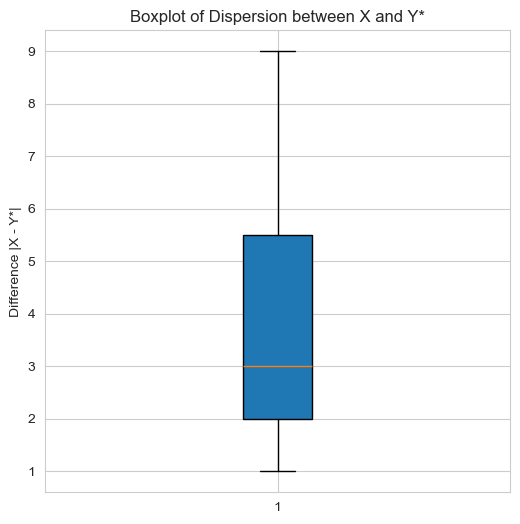

In [311]:
# Tracer les variations entre No-show X et Optimal Overbooking Y_star
plot_no_show_vs_overbooking(no_show_vs_overbooking_data)

# Tracer le boxplot de la dispersion moyenne entre X et Y_star
plot_dispersion_boxplot(no_show_vs_overbooking_data)

## generic distribution

In [313]:
import numpy as np
import pandas as pd
from scipy.stats import norm
import matplotlib.pyplot as plt

# Fonction pour calculer la critical fractile
def calculate_critical_fractile(lambda_cost, rho_cost):
    return lambda_cost / (lambda_cost + rho_cost)

# Fonction pour calculer le niveau optimal d'overbooking en utilisant la méthode générique
def generic_calculate_optimal_overbooking_level(F_Y, no_show_history):
    """
    Calcule le niveau optimal d'overbooking Y* en fonction de la critical fractile F_Y
    et des probabilités cumulées dans no_show_history.

    Parameters:
    - F_Y: float, la critical fractile.
    - no_show_history: DataFrame, historique des No-show avec une colonne 'no_show_count' et 'cumulative_probability'.

    Returns:
    - Y_star: int, le niveau optimal d'overbooking.
    """
    # Trier les No-shows par nombre croissant
    sorted_no_shows = no_show_history.sort_values(by='no_show_count')
    
    # Calculer les probabilités cumulées
    sorted_no_shows['cumulative_probability'] = sorted_no_shows['no_show_count'].cumsum() / sorted_no_shows['no_show_count'].sum()
    
    # Trouver le nombre de No-show dont la probabilité cumulée est la plus proche de F_Y
    Y_star = sorted_no_shows.iloc[(sorted_no_shows['cumulative_probability'] - F_Y).abs().argsort()[:1]]['no_show_count'].values[0]
    
    return Y_star

# Fonction pour calculer les temps morts (Idle Time)
def calculate_I(X, Y, service_times):
    sum_X = np.sum(service_times[:X])
    sum_Y = np.sum(service_times[:Y])
    I = max(0, sum_X - sum_Y)
    return I

# Fonction pour calculer les temps d'attente (Waiting Time)
def calculate_W(X, Y, service_times):
    sum_X = np.sum(service_times[:X])
    sum_Y = np.sum(service_times[:Y])
    W = max(0, sum_Y - sum_X)
    return W

# Fonction pour calculer les moyennes des temps morts et temps d'attente
def calculate_mean_I_W(X, Y, service_times):
    I = calculate_I(X, Y, service_times)
    W = calculate_W(X, Y, service_times)
    mean_I = I / abs(X - Y) if abs(X - Y) > 0 else 0
    mean_W = W / abs(X - Y) if abs(X - Y) > 0 else 0
    return mean_I, mean_W

# Fonction pour traiter les N derniers jours pour un sta3n donné
def process_last_n_days(data, lambda_cost, rho_cost, no_show_history, sta3n=657, num_days=10):
    data = data.sort_values(by='activitydatetime')
    
    # Filtrer par sta3n
    data = data[data['sta3n'] == sta3n]
    
    # Sélectionner les N derniers jours
    last_n_days = data['activitydatetime'].dt.date.unique()[-num_days:]
    
    # Filtrer le DataFrame pour ces N jours
    data_last_n_days = data[data['activitydatetime'].dt.date.isin(last_n_days)]
    
    # Trier par ordre décroissant selon la date
    data_last_n_days = data_last_n_days.sort_values(by='activitydatetime', ascending=False)
    
    # Initialiser une liste pour stocker les résultats
    results = []
    no_show_vs_overbooking = []

    for day in last_n_days:
        day_data = data_last_n_days[data_last_n_days['activitydatetime'].dt.date == day]
        
        # Nombre de No-show
        X = day_data['NoShow'].sum()

        # Calculer F(Y) pour la journée
        F_Y = calculate_critical_fractile(lambda_cost, rho_cost)

        # Calculer Y* pour la journée en utilisant les probabilités cumulées
        Y_star = generic_calculate_optimal_overbooking_level(F_Y, no_show_history)

        # Extraire les temps de service
        service_times = day_data['service_time'].values

        # Calculer les valeurs moyennes de I et W
        mean_I, mean_W = calculate_mean_I_W(X, Y_star, service_times)

        # Ajouter la variation X et Y
        no_show_vs_overbooking.append({'date': day, 'X': X, 'Y_star': Y_star, 'diff': abs(X - Y_star)})

        # Ajouter les résultats à la liste
        results.append({'date': day, 'mean_I': mean_I, 'mean_W': mean_W})

    # Convertir les résultats en DataFrame pour analyse
    results_data = pd.DataFrame(results)
    no_show_vs_overbooking_data = pd.DataFrame(no_show_vs_overbooking)

    return results_data, no_show_vs_overbooking_data

# Fonction pour tracer les variations de Waiting Time et Idle Time
def plot_variations(results_data):
    plt.figure(figsize=(12, 6))
    plt.plot(results_data['date'], results_data['mean_W'], marker='o', label='Mean Waiting Time')
    plt.plot(results_data['date'], results_data['mean_I'], marker='o', label='Mean Idle Time')
    plt.xlabel('Date')
    plt.ylabel('Time')
    plt.title('Variations of Mean Waiting Time and Mean Idle Time')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonction pour tracer les boxplots de Waiting Time et Idle Time
def plot_boxplots(results_data):
    plt.figure(figsize=(12, 6))
    
    # Boxplot pour Mean Waiting Time
    plt.subplot(1, 2, 1)
    plt.boxplot(results_data['mean_W'], patch_artist=True)
    plt.title('Boxplot of Mean Waiting Time')
    plt.ylabel('Time')
    
    # Boxplot pour Mean Idle Time
    plt.subplot(1, 2, 2)
    plt.boxplot(results_data['mean_I'], patch_artist=True)
    plt.title('Boxplot of Mean Idle Time')
    
    plt.show()

# Fonction pour tracer les variations entre No-show X et Y_star
def plot_no_show_vs_overbooking(no_show_vs_overbooking_data):
    plt.figure(figsize=(12, 6))
    plt.plot(no_show_vs_overbooking_data['date'], no_show_vs_overbooking_data['X'], marker='o', label='No-show (X)', color='blue')
    plt.plot(no_show_vs_overbooking_data['date'], no_show_vs_overbooking_data['Y_star'], marker='o', label='Optimal Overbooking (Y*)', color='orange')
    plt.xlabel('Date')
    plt.ylabel('Number')
    plt.title('Variations of No-show (X) vs Optimal Overbooking Y*')
    plt.legend()
    plt.grid(True)
    plt.show()

# Fonction pour tracer les boxplots de la dispersion moyenne entre X et Y
def plot_dispersion_boxplot(no_show_vs_overbooking_data):
    plt.figure(figsize=(6, 6))
    plt.boxplot(no_show_vs_overbooking_data['diff'], patch_artist=True)
    plt.title('Boxplot of Dispersion between X and Y*')
    plt.ylabel('Difference |X - Y*|')
    plt.show()

# Exemple d'utilisation
lambda_cost = 100
rho_cost = 50
sta3n = 657
num_days = 10  # Vous pouvez changer ce nombre selon vos besoins

# Supposez que no_show_history a été pré-calculé et contient les probabilités cumulées
# no_show_history est un DataFrame avec des colonnes 'no_show_count' et 'cumulative_probability'

# Calculer les variations pour les N derniers jours pour un sta3n spécifique
results_data, no_show_vs_overbooking_data = process_last_n_days(data, lambda_cost, rho_cost, no_show_history, sta3n=sta3n, num_days=num_days)

# Tracer les variations des temps d'attente et des temps morts
plot_variations(results_data)

# Tracer les boxplots des temps d'attente et des temps morts
plot_boxplots(results_data)

# Tracer les variations entre X et Y*
plot_no_show_vs_overbooking(no_show_vs_overbooking_data)

# Tracer le boxplot pour mesurer la dispersion entre X et Y*
plot_dispersion_boxplot(no_show_vs_overbooking_data)


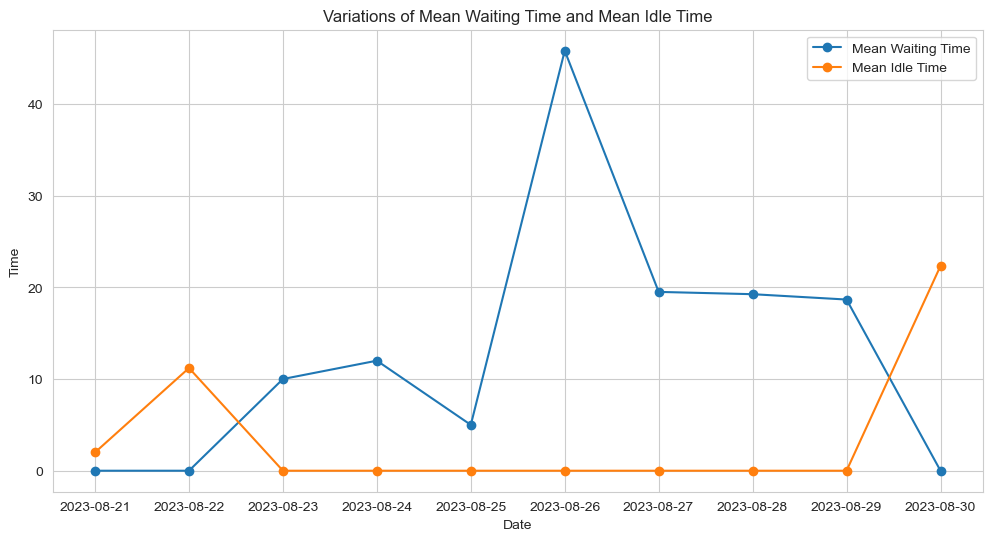

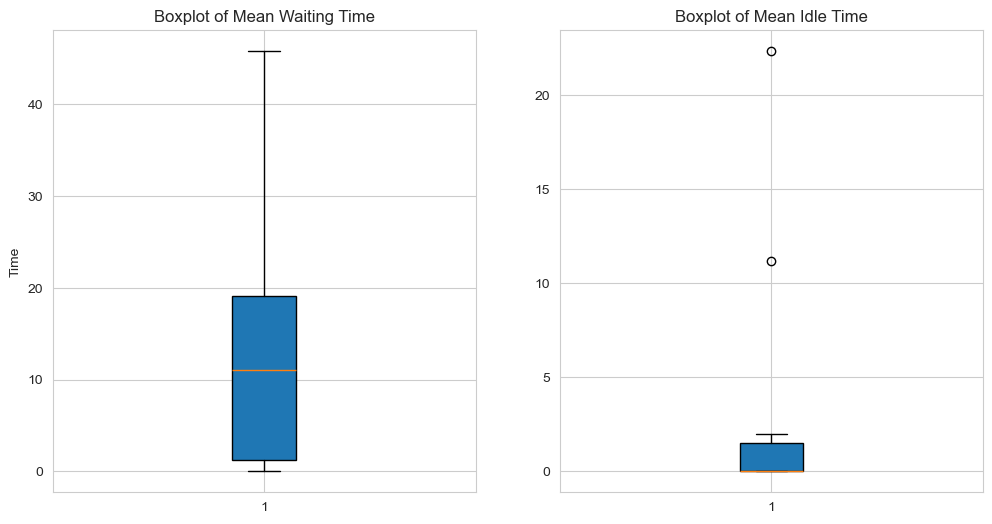

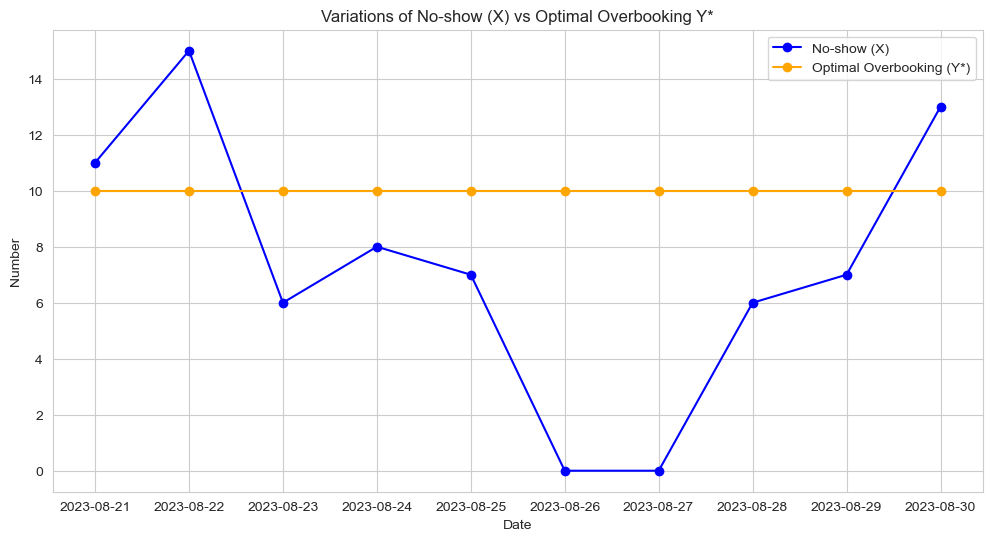

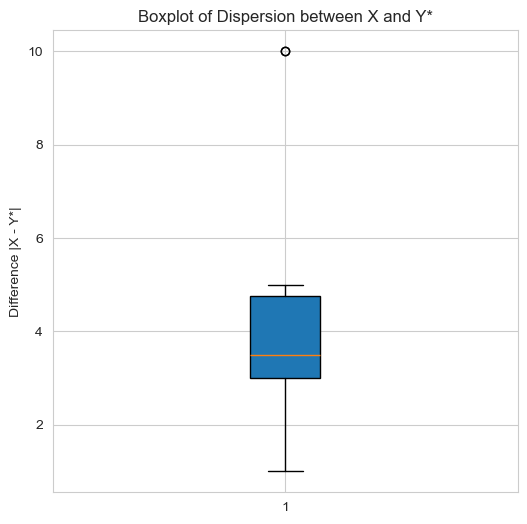

In [315]:
lambda_cost = 2
rho_cost = 1
sta3n = 657
num_days = 10  

# Supposez que no_show_history a été pré-calculé et contient les probabilités cumulées
# no_show_history est un DataFrame avec des colonnes 'no_show_count' et 'cumulative_probability'

# Calculer les variations pour les N derniers jours pour un sta3n spécifique
results_data, no_show_vs_overbooking_data = process_last_n_days(df, lambda_cost, rho_cost, no_show_history, sta3n=sta3n, num_days=num_days)

# Tracer les variations des temps d'attente et des temps morts
plot_variations(results_data)

# Tracer les boxplots des temps d'attente et des temps morts
plot_boxplots(results_data)

# Tracer les variations entre X et Y*
plot_no_show_vs_overbooking(no_show_vs_overbooking_data)

# Tracer le boxplot pour mesurer la dispersion entre X et Y*
plot_dispersion_boxplot(no_show_vs_overbooking_data)